# Live Training for Pearson Learning
## Time Series Analysis and Forecasting for Beginners


## Section 5: Seasonal ARIMA Modeling

In [31]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
import os

import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def tsplot(y, title='TITLE', xlabel='X Label', ylabel='Y Label', figsize=(12, 8)):
    '''
    Plot the time series plot
    '''
    fig, ax = plt.subplots(figsize=figsize)
        
    y.plot(ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    sns.despine()
    fig.tight_layout()

In [33]:
def tsplot2(y, lags=None, title='', figsize=(16, 10)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

### Motivation of Using Seasonal ARIMA Model

In [34]:
# Import a time series

air = pd.read_csv('data/international-airline-passengers.csv', header=0, index_col=0, parse_dates=[0])

In [35]:
# Examine the basic structure of the data
print("Data shape:", air.shape, "\n")
print("First 5 observations of the data series:", "\n", air.head())
print("Last 5 observations of the data series:", "\n", air.tail())

Data shape: (144, 1) 

First 5 observations of the data series: 
             n_pass_thousands
Month                       
1949-01-01               112
1949-02-01               118
1949-03-01               132
1949-04-01               129
1949-05-01               121
Last 5 observations of the data series: 
             n_pass_thousands
Month                       
1960-08-01               606
1960-09-01               508
1960-10-01               461
1960-11-01               390
1960-12-01               432


In [36]:
def tsplot2(y, lags=None, title='', figsize=(16, 10)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    #ts_ax.legend(loc='lower right', prop={'size': 10})
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    ts_ax.set_xticklabels(y.index.year.tolist(), rotation=45)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    #[ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

## Create a training sample and testing sample

In [37]:
air_train = air[:'1958']
air_test  = air['1959':]

# Take log of the series
air['lnair'] = np.log(air)

lnair_train = air['lnair'][:'1958']
lnair_test  = air['lnair']['1959':]

print(air_train.shape)
print(air_test.shape)
print("Training Series:", "\n", air_train.tail(), "\n")
print("Testing Series:", "\n", air_test.head(1))

(120, 1)
(24, 1)
Training Series: 
             n_pass_thousands
Month                       
1958-08-01               505
1958-09-01               404
1958-10-01               359
1958-11-01               310
1958-12-01               337 

Testing Series: 
             n_pass_thousands
Month                       
1959-01-01               360


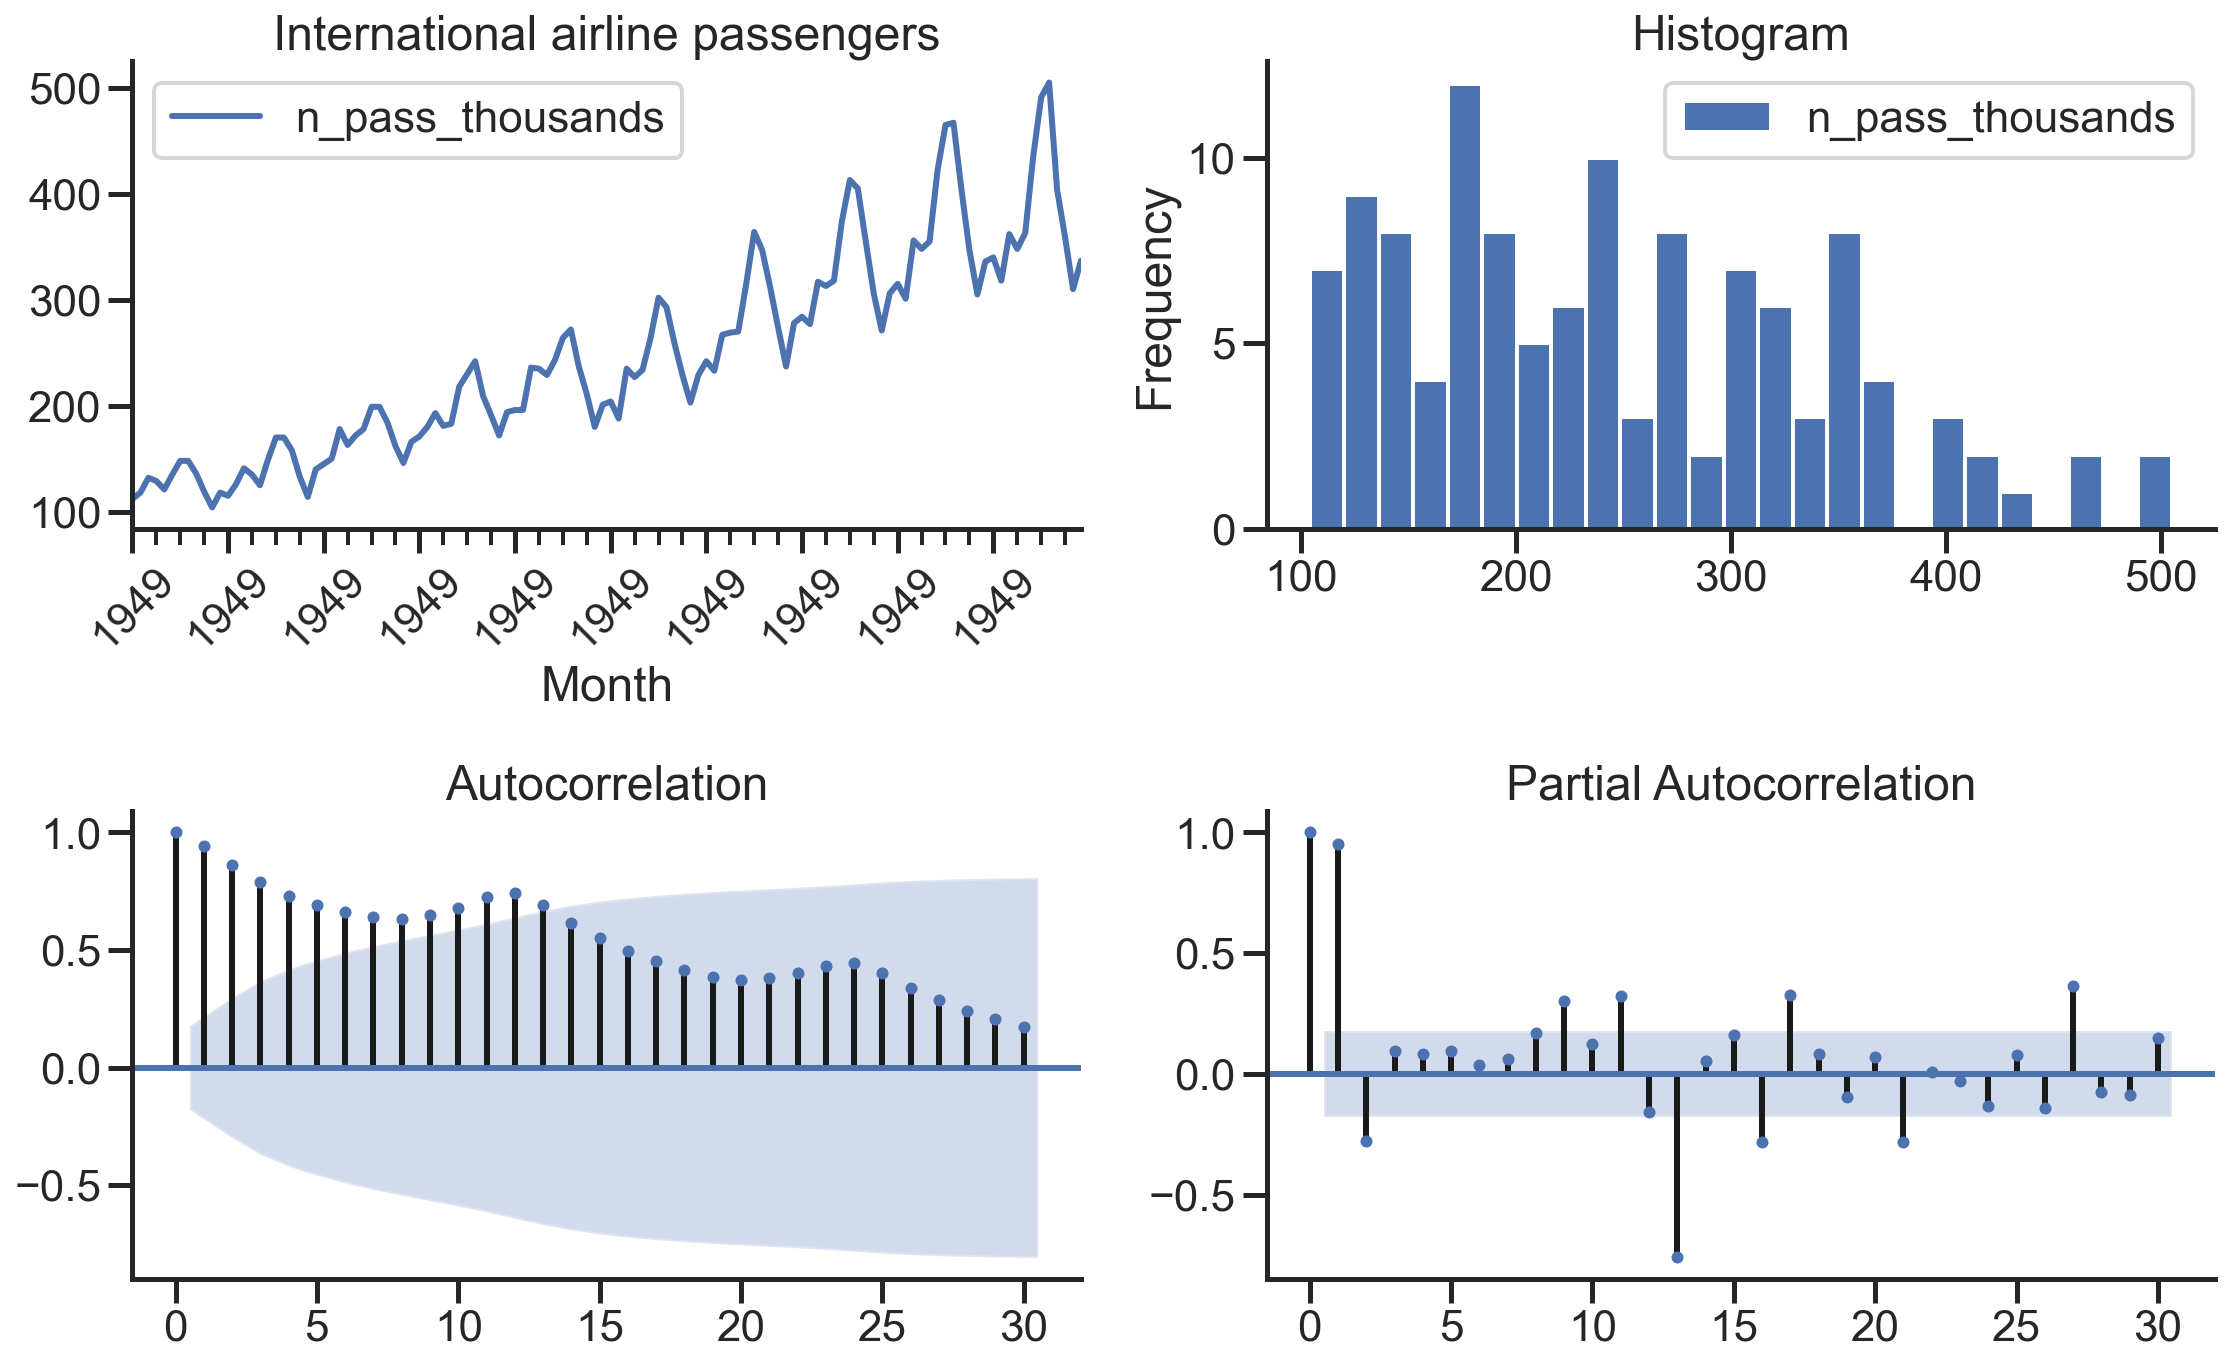

In [38]:
_ = tsplot2(air_train, title='International airline passengers', lags=30)

**Observations:**

* The airline passengers series displays an increasing trend (over time)
* Strong *seasonality*
* Variance increases over time
* The autocorrelations do not just gradually decline

In [39]:
print(lnair_train.head(),"\n")
print(lnair_train.shape,"\n")

# Take first difference of the series
lnair_train_diff1 = lnair_train.diff(1)
lnair_train_diff1 = lnair_train_diff1.dropna()

# Take seasonal difference of the series
lnair_train_diff12 = lnair_train.diff(12)
lnair_train_diff12 = lnair_train_diff12.dropna()

print(lnair_train_diff1.head(),"\n")
print(lnair_train_diff1.shape,"\n")

print(lnair_train_diff12.head(),"\n")
print(lnair_train_diff12.shape,"\n")

Month
1949-01-01   4.71850
1949-02-01   4.77068
1949-03-01   4.88280
1949-04-01   4.85981
1949-05-01   4.79579
Name: lnair, dtype: float64 

(120,) 

Month
1949-02-01    0.05219
1949-03-01    0.11212
1949-04-01   -0.02299
1949-05-01   -0.06402
1949-06-01    0.10948
Name: lnair, dtype: float64 

(119,) 

Month
1950-01-01   0.02643
1950-02-01   0.06560
1950-03-01   0.06596
1950-04-01   0.04546
1950-05-01   0.03252
Name: lnair, dtype: float64 

(108,) 



**Log transformation stablizes the variance of the series**

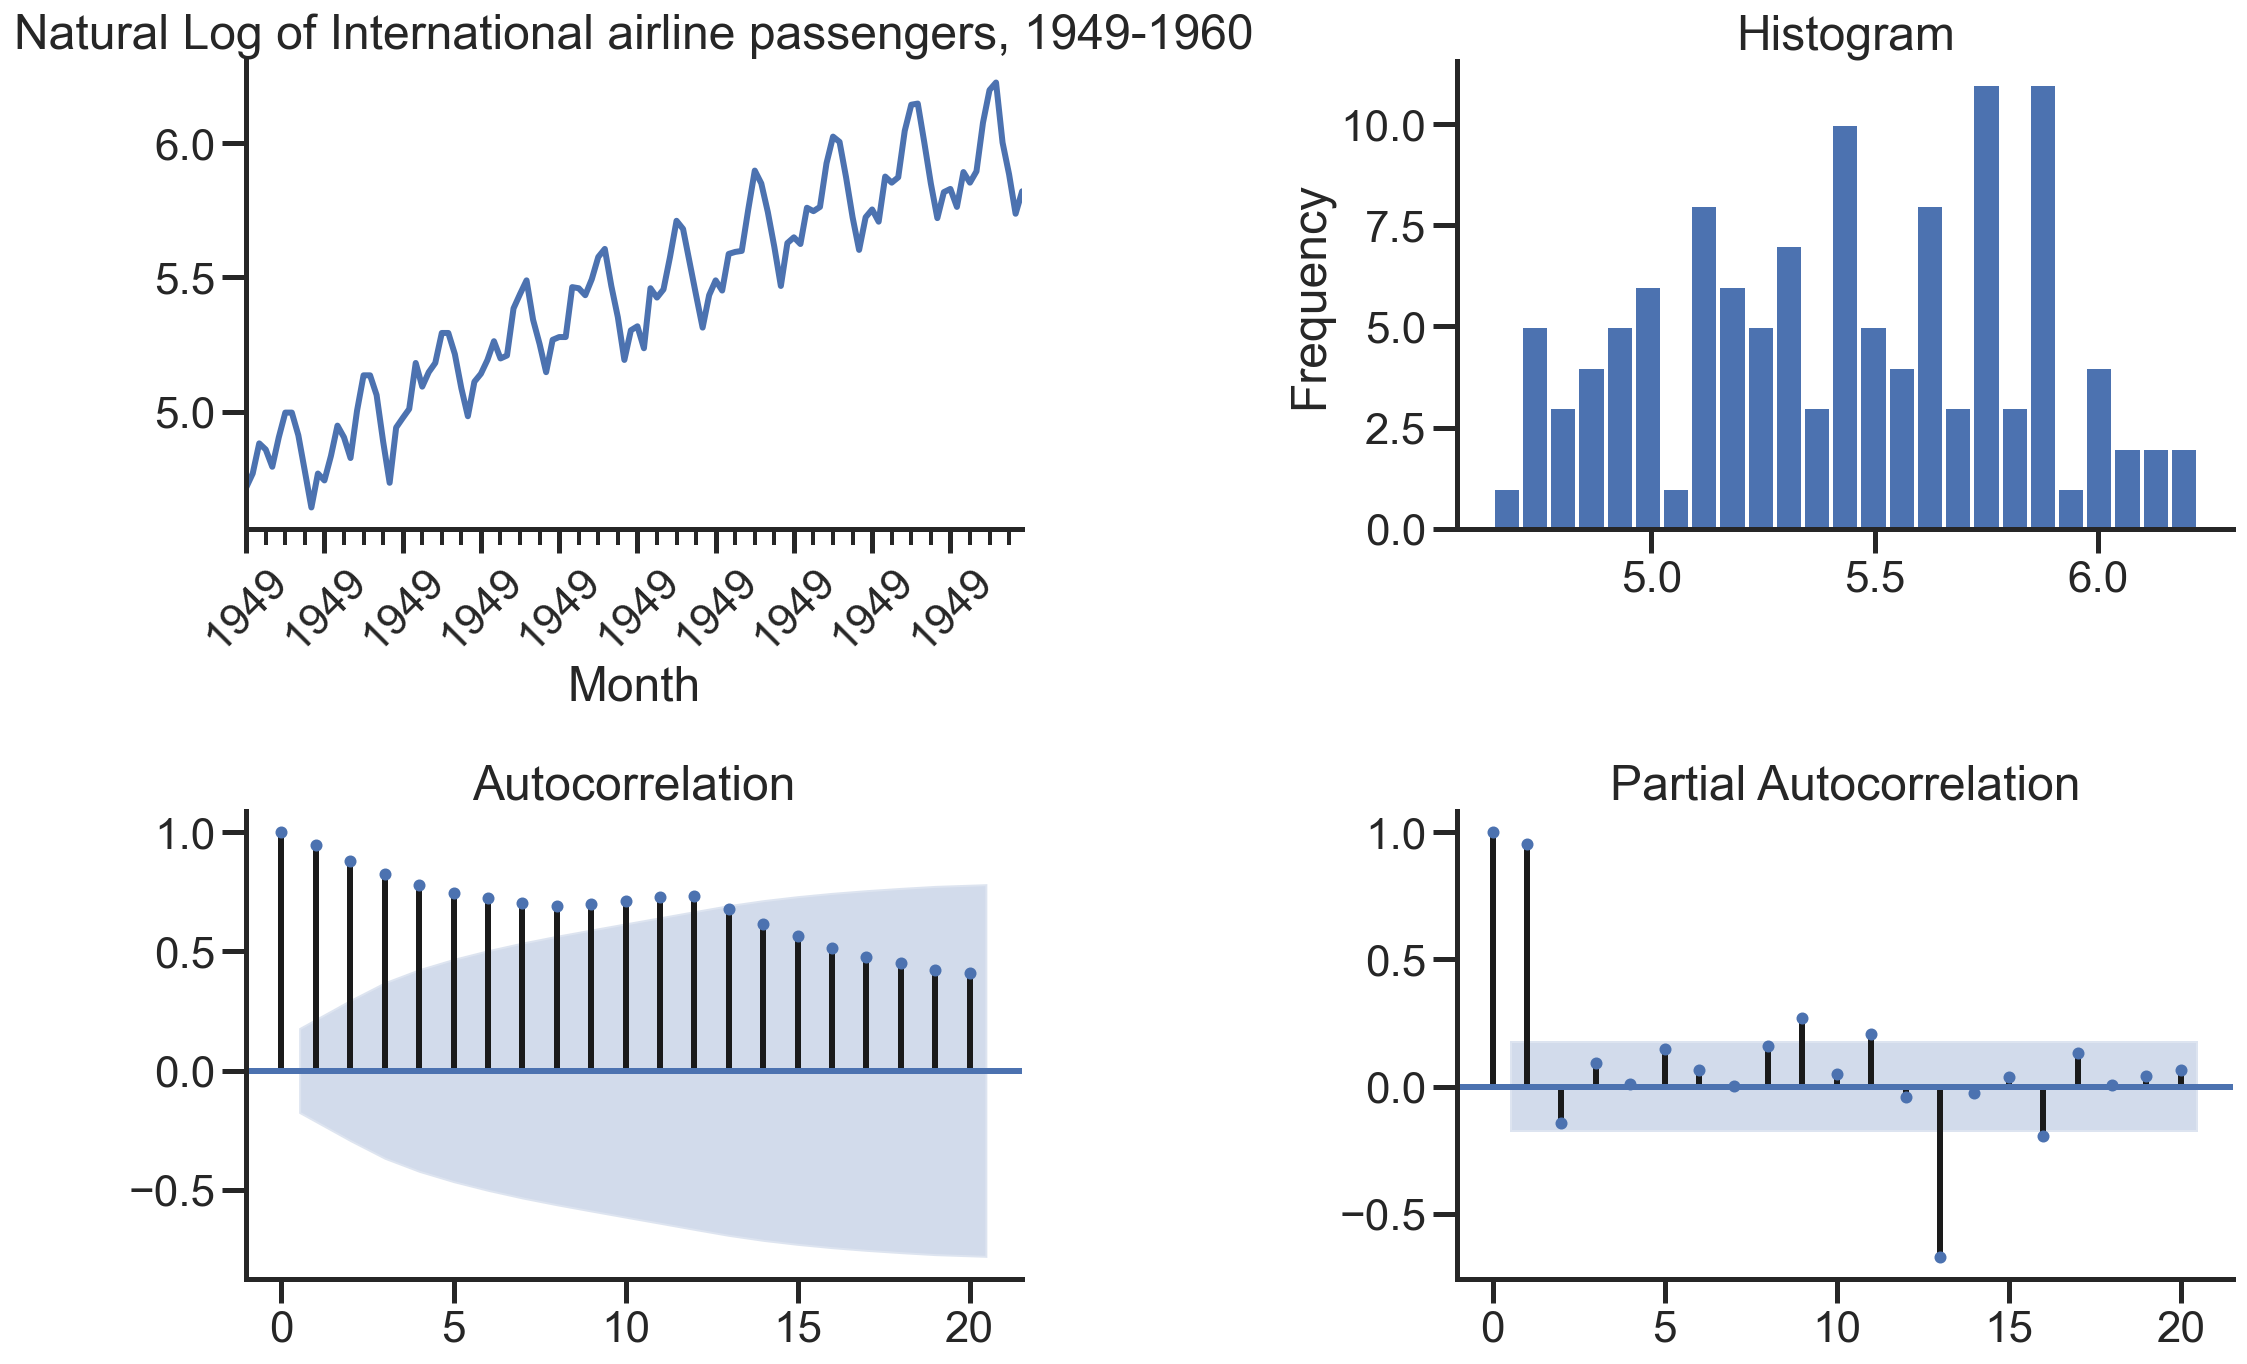

In [40]:
tsplot2(lnair_train, title='Natural Log of International airline passengers, 1949-1960', lags=20);

**Taking first difference in the log of the series remove the trend, though seasonality remains**

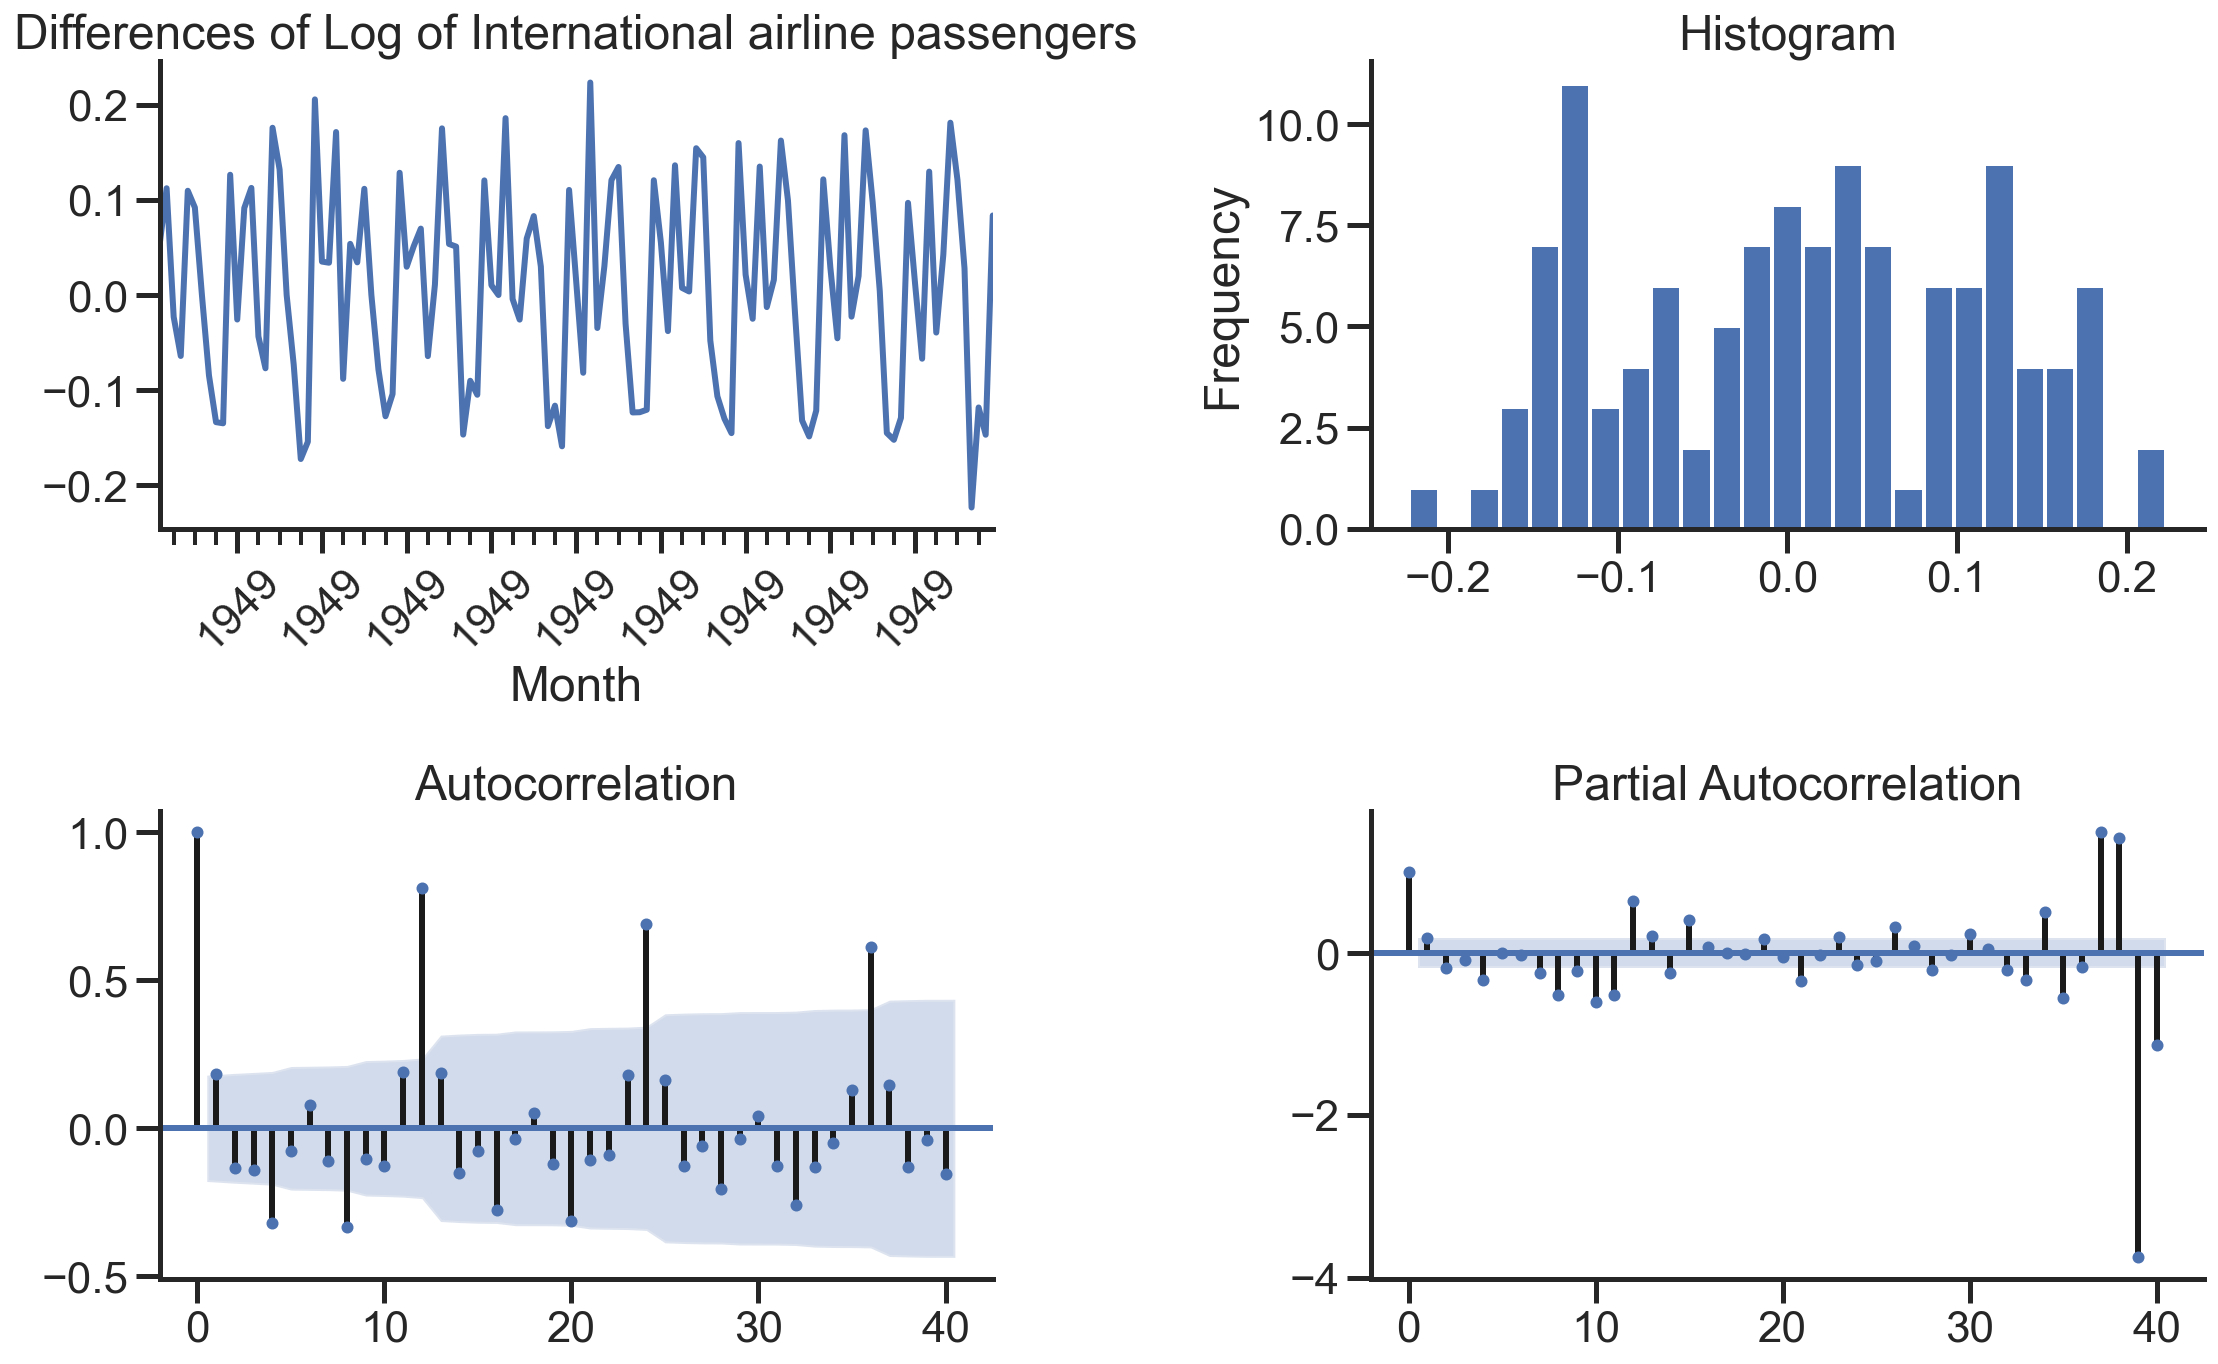

In [41]:
tsplot2(lnair_train_diff1, title='Differences of Log of International airline passengers', lags=40);

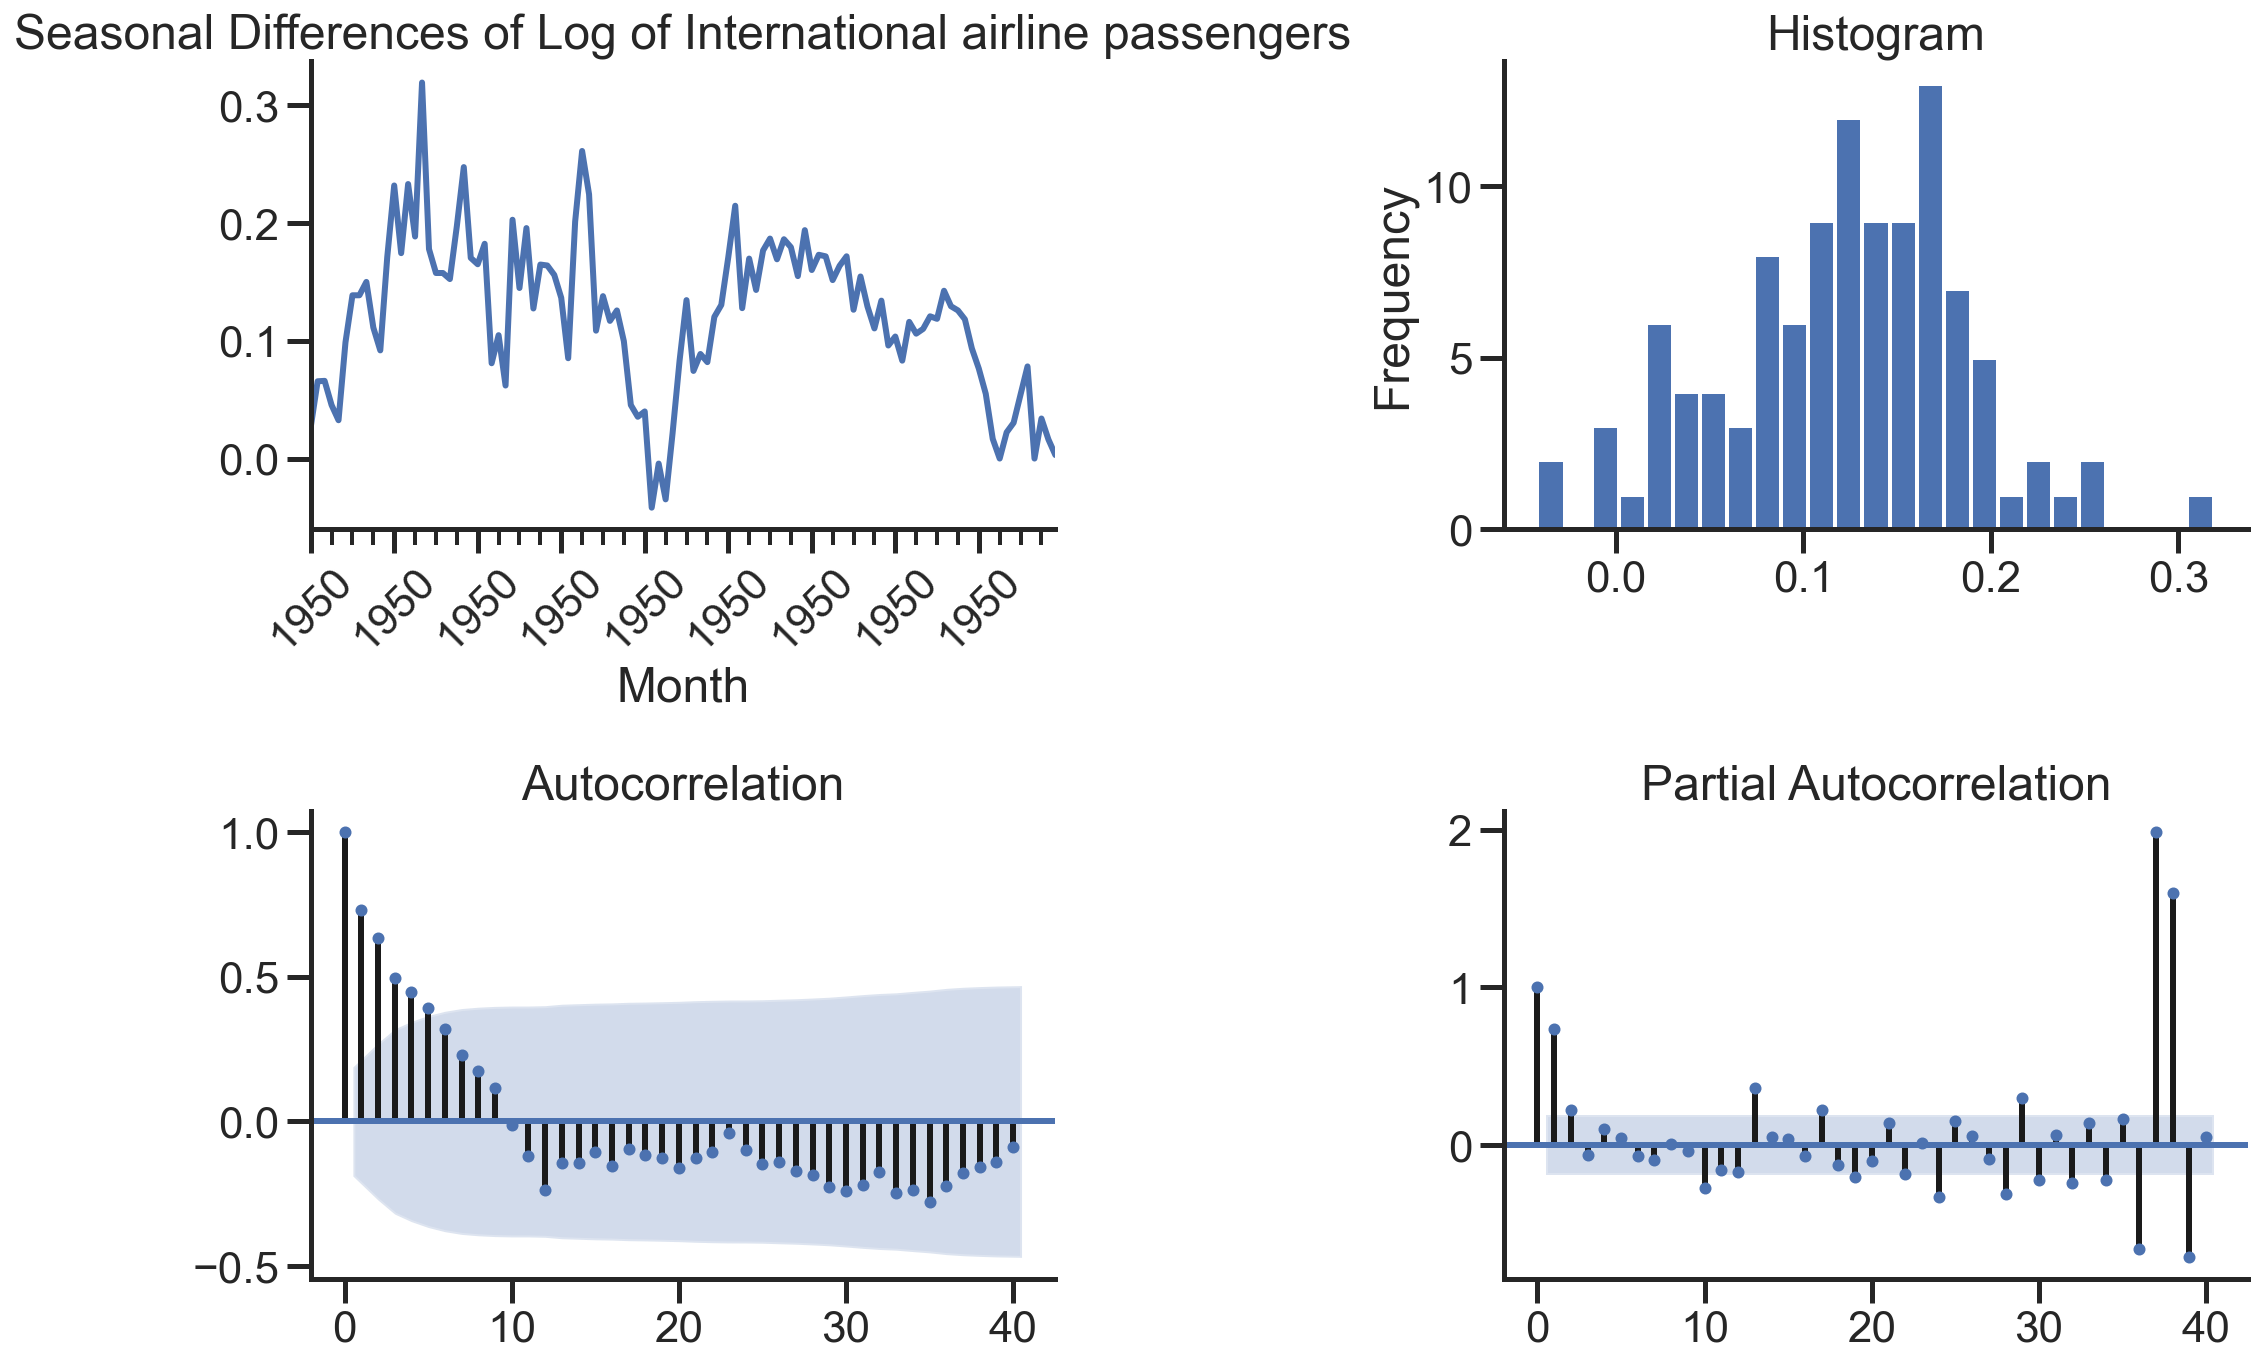

In [42]:
tsplot2(lnair_train_diff12, title='Seasonal Differences of Log of International airline passengers', lags=40);

**Remember that we can also use boxplot to (visually) detect seasonality**

In [43]:
air_train

,n_pass_thousands
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1958-08-01,505
1958-09-01,404
1958-10-01,359


## For take-home study: Formulation of the Seasonal ARIMA Model and Some Examples (Note: that I will use explain it in the lecture using my slides)

The *pure* seasonal autoregressive and moving average model, $ARMA(P,Q)$, take the from

$$\Phi_P(B^s)z_t=\Theta_Q(B^s)\epsilon_t$$ 

where 

$$\Phi_P(B^2)=1 - \Phi_1 B^s - \Phi_2 B^{2s} - \cdots - \Phi_P B^{Ps}$$

and 

$$\Theta_Q(B^2)=1 - \Theta_1 B^s - \Theta_2 B^{2s} - \cdots - \Theta_Q B^{Qs}$$

are the **seasonal autoregressive operator** and the **seasonal moving average operator** of orders $P$ and $Q$ with **seasonal period s**.

**Example:**

A first-order seasonal autoregressive moving average series over months (or $SARIMA(1,0,1,12)$) can be expressed as

$$ z_t = \Phi z_{t-12} + \epsilon_t + \Theta \epsilon_{t-12} $$

or

$$ (1 - \Phi B^{12})z_t = (1 + \Theta B^{12})\epsilon_t $$

In other words, this model capture the relationship between $z_t$ and its lags at the multiple of the yearly seasonal period $s=12$ months.  

The stationarity condition requires that $|\Phi|<1$ and the invertible condition requires that $|\Theta|<1$.

Similar to that for the ARIMA models, the table below summarize the behavior of the theoretical ACF and PACF of the pure seasonal ARMA models:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(P)**     |    tails off         | cutoff after lag $P$ |
| **MA(Q)**     | cutoff after lag $Q$ |    tails off         |
| **ARMA(P,Q)** |    tails off         |    tails off         |

* **Note that we use (p,d,q) to denote the orders for the non-seasonal components of the ARIMA models and (P,D,Q,s) to denote the orders for the seasonal components of the ARIMA model.**

The general formulation of the **Multiplicative Seasonal Autoregressive Integrated Moving Average (SARIMA)** model takes the following form:

$$ \phi_p(B) \Phi_P(B^s) \bigtriangledown^d \bigtriangledown^D_s z_t = \theta_q(B) \Theta_Q(B^s) \epsilon_t $$ 

where 

$\epsilon_t$ is a white noise process

$\phi_p(B)$ and $\theta_q(B)$ are non-seasonal autoregressive and moving average lag polynomials

$\Phi_P(B^s)$ and $\Theta_Q(B^s)$ are seasonal autoregressive and moving average lag polynomials

$\bigtriangledown^d \equiv (1-B)^d$ and $\bigtriangledown^D_s \equiv (1-B^s)^D$ are the difference (or integrated) components

Therefore, the general model is denoted as $\mathbf{ARIMA(p,d,q)\times(P,D,Q)_s}$



**Example:**

Unpacking the notation, the $\mathbf{ARIMA(0,1,1)\times(P,1,1)_{12}}$ model becomes

$$(1-B)(1-B^{12})z_t = (1+\theta B)(1+\Theta B^{12}) \epsilon_t$$

When multiplying the lag polynomials on both side, we get

$$ (1 - B - B^{12} + B^{13}) z_t = (1 + \theta B + \Theta B^{12} + \theta \Theta B^{13}) \epsilon_t $$

Simplify gives

$$ z_t = z_{t-1} + (z_{t-12} - z_{t-13}) + \epsilon_t + \theta \epsilon_{t-1} + \Theta \epsilon_{t-12} + \theta \Theta \epsilon_{t-13}$$


# Building a Seasonal ARIMA Model for Forecasting
## Example using the famous "Airline" Model

In [47]:
# Air Passengers Series
sarima_model = sm.tsa.statespace.SARIMAX(air['lnair'], order=(2,1,0), seasonal_order=(1,1,0,12))
sarima_result = sarima_model.fit()
print(sarima_result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              lnair   No. Observations:                  144
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 240.821
Date:                            Sat, 06 Mar 2021   AIC                           -473.642
Time:                                    02:43:19   BIC                           -462.142
Sample:                                01-01-1949   HQIC                          -468.969
                                     - 12-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4069      0.080     -5.057      0.000      -0.565      -0.249
ar.L2         -0.0792      0.099   

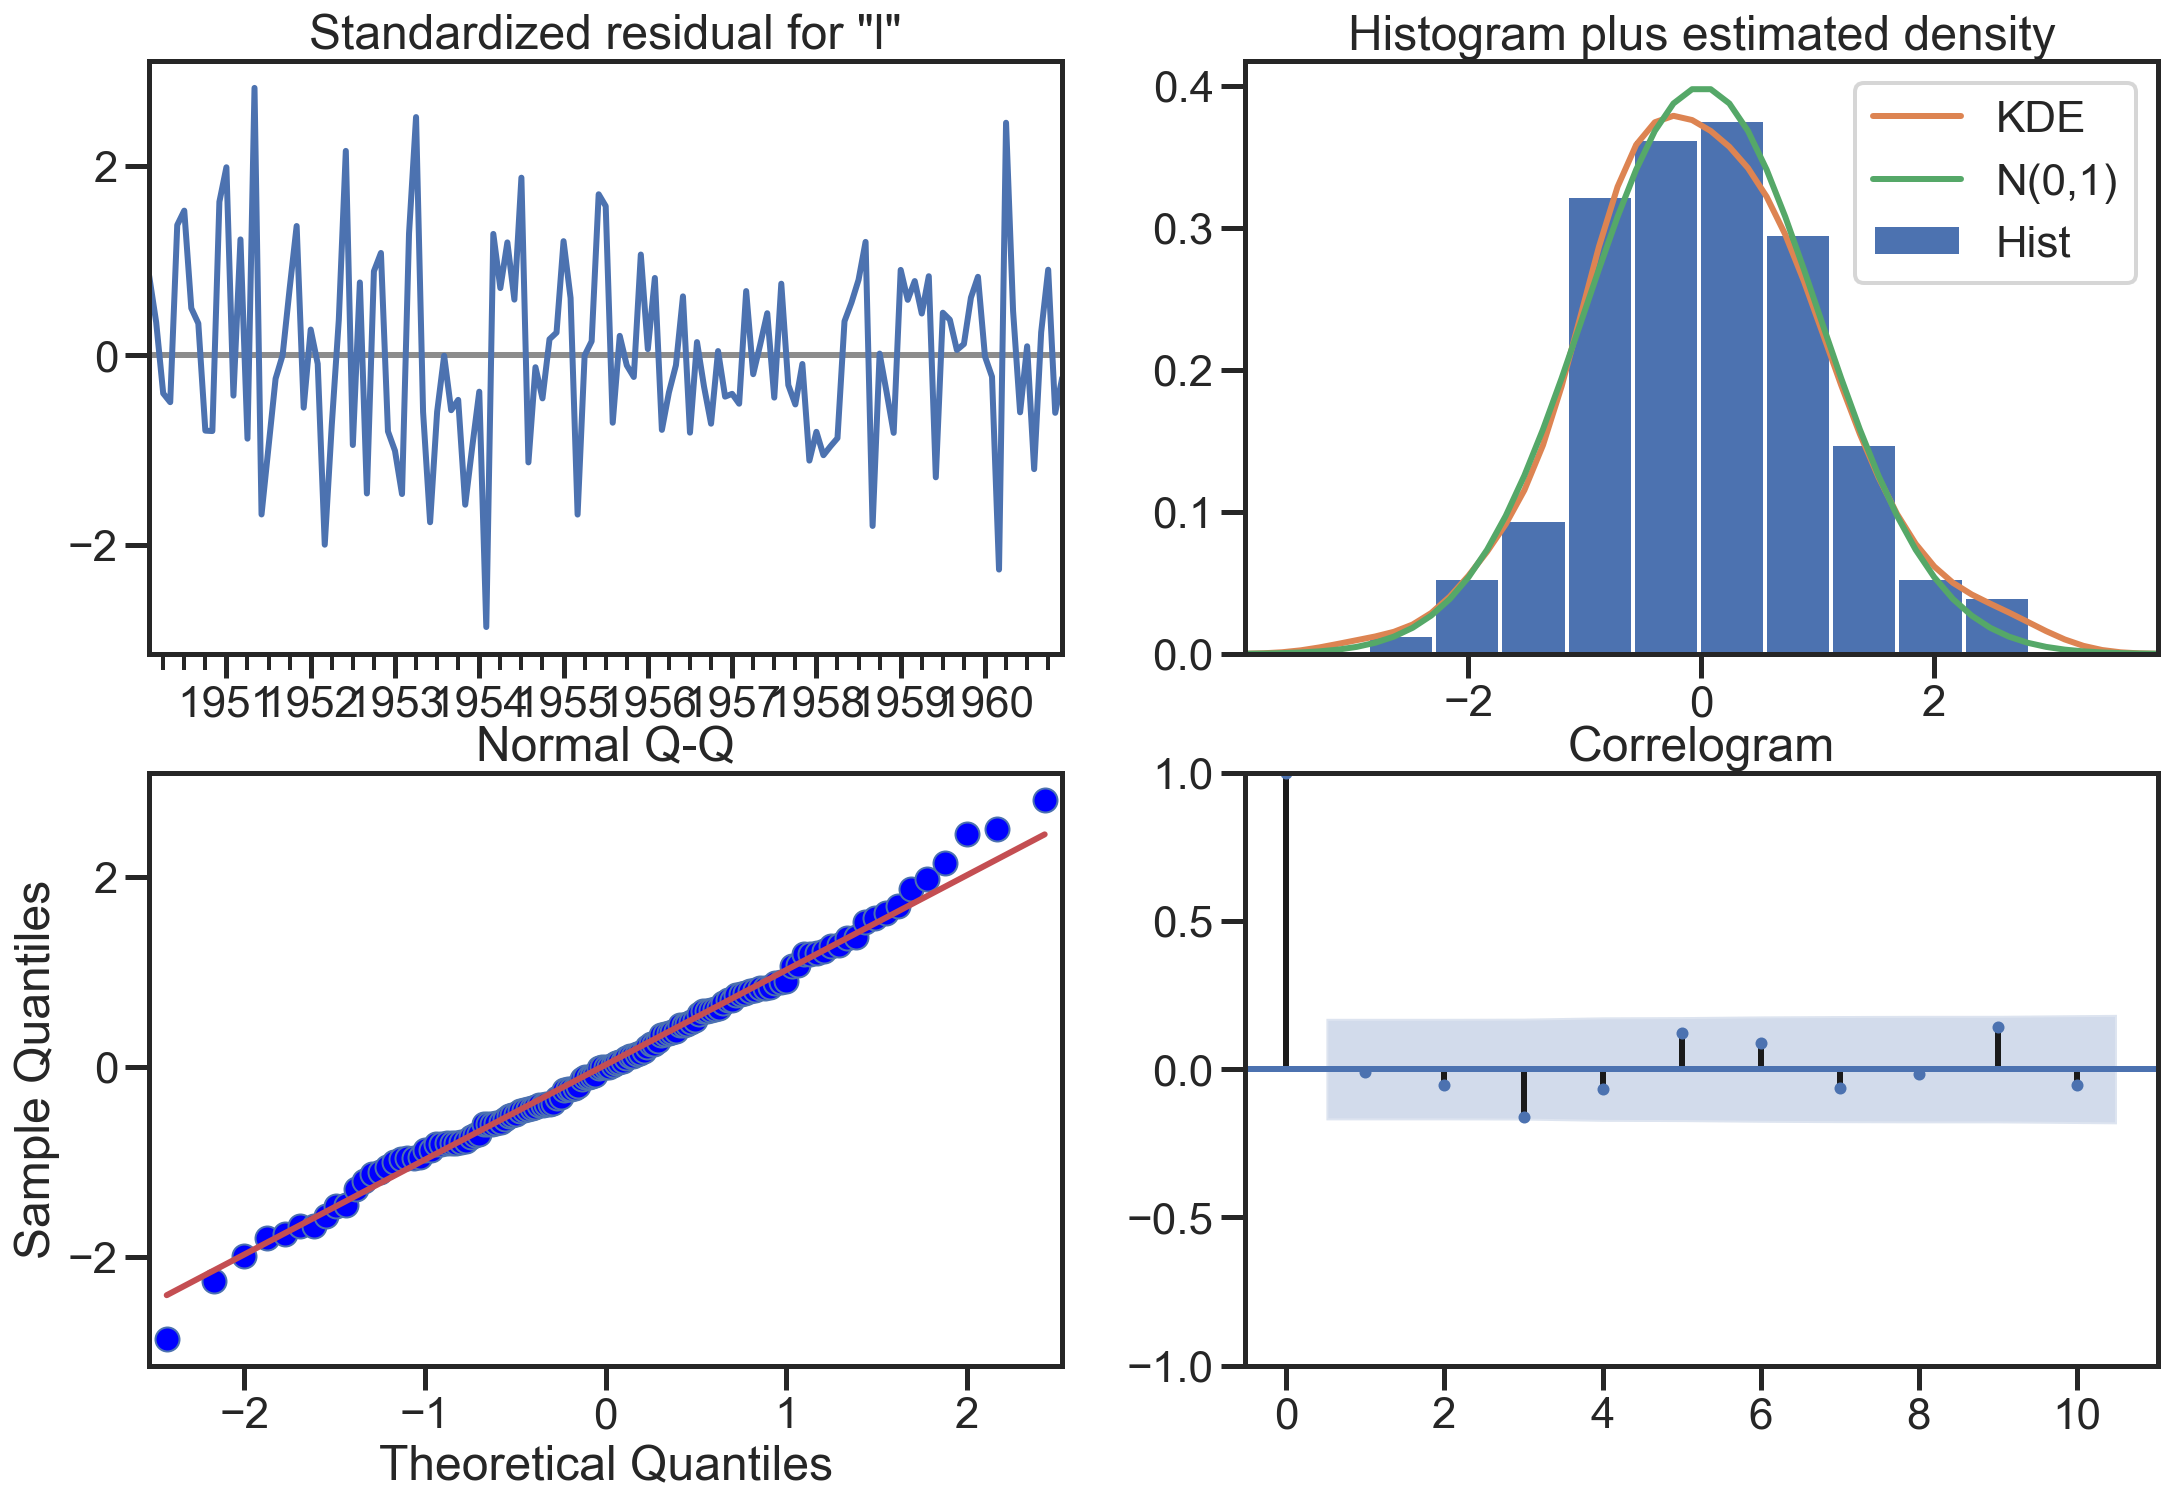

In [48]:
# Model Diagnostic

sarima_result.plot_diagnostics(figsize=(18, 12));

# Exercise 

Continue with this exericse by producing the forecast, plot the observed train and test series, fitted values, forecast values, and 95% confidence intervals.

All the codes are in the previous notebooks.